# Finding donors for charity using ML

In this project, I use various supervised learning alogirthms to predict an individual's income using data collected from the 1994 U.S Census. I then selected the best algorithm and then further optimized this algorithm to best model the data. My goal is to predict whether an individual makes more than $50,000. This can help non-profit organisations better understand how large of a donation to request, or whether or not they should reach out to certain individuals.

The dataset originates from the https://archive.ics.uci.edu/ml/datasets/Census+Income .

## Data Exploration

I started off by importing the necessary libraries, reading the data and exploring the dataset.

In [2]:
import numpy as np
import pandas as pd
from time import time
#from Ipython.display import display # allowws rhe use of display() for Dataframes

# Import visualisation libraries
#import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#from __future__import division

# Load the census dataset
data = pd.read_csv(r'link to dataset')
# Drop fnlwgt column
data = data.drop('fnlwgt', axis=1)
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


This dataset can determine how many individuals fit into either groups and the percentage of these individuals who make more than $50,000

In [3]:
# FInding special characters in the dataframe
data.isin(['?']).sum(axis=0)

age                  0
workclass         2799
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [4]:
# We replace the special characters to nan 
data['workclass'] = data['workclass'].replace('?',np.nan)
data['occupation'] = data['occupation'].replace('?',np.nan)
data['native-country'] = data['native-country'].replace('?',np.nan)
 
#dropping the NaN rows now
df_drop= pd.DataFrame(data, columns=data.columns,index=data.index) 
df_drop.dropna(how='any',inplace=True)

In [5]:
# Statisctical summary
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382
std,13.710510,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# Categorical features
data.describe(include=object)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


In [7]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 48842
Individuals making more than $50,000: 11687
Individuals making at most $50,000: 37155
Percentage of individuals making more than $50,000: 23.93%


## Exploratory Data Analysis

        Count       %
Male    32650  66.85%
Female  16192  33.15%


Text(0.5, 1.0, 'Gender distribution')

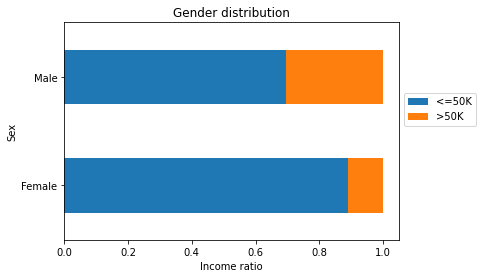

In [8]:
# Gender ratio
gender = data.sex
counts = gender.value_counts()
percentage = gender.value_counts(normalize=True).mul(100).round(2).astype(str)+'%'
tab = pd.DataFrame({"Count": counts, "%": percentage})
print(tab)

# Gender distribution
gender_group = data.groupby(['sex', 'income']).size().unstack()
gender_group.apply(lambda x:x/x.sum(), axis=1).plot(kind='barh', stacked=True, legend=False)
plt.legend(['<=50K', '>50K'], bbox_to_anchor=(1.0, 0.7))
plt.ylabel('Sex')
plt.xlabel('Income ratio')
plt.title("Gender distribution")

We notice there's more men making more than $50,000

<AxesSubplot:>

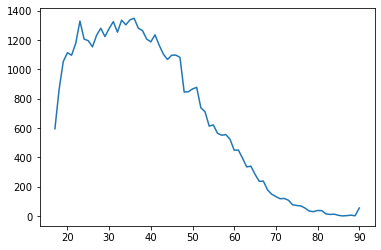

In [9]:
# Age distribution
data['age'].value_counts().sort_index().plot.line()

In [10]:
# Getting average working hour per country with income
pd.crosstab(data['native-country'], data['income'], 
           values=data['hours-per-week'], aggfunc=np.mean)

income,<=50K,>50K
native-country,,
Cambodia,41.157895,43.888889
Canada,37.378151,46.126984
China,36.686047,42.027778
Columbia,39.123457,56.250000
Cuba,39.201923,42.852941
Dominican-Republic,41.561224,42.800000
Ecuador,37.948718,47.833333
El-Salvador,35.819444,43.454545
England,39.375000,46.297872


Text(0.5, 1.0, 'Education distribution')

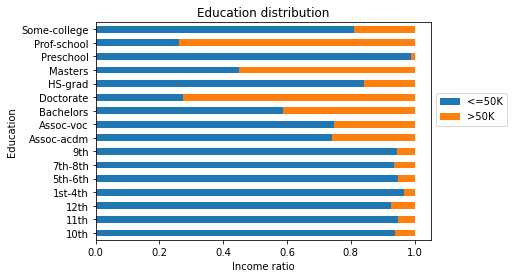

In [11]:
#eductaion distribution; 
edu_group = data.groupby(['education', 'income']).size().unstack()
edu_group.apply(lambda x:x/x.sum(), axis=1).plot(kind='barh', stacked=True, legend=False) # apply(lambda x:x/x.sum(), axis=1) is used to get percentage Bar plots
plt.legend(['<=50K', '>50K'], bbox_to_anchor=(1.0, 0.7))
plt.ylabel('Education')
plt.xlabel('Income ratio')
plt.title("Education distribution")

Text(0.5, 1.0, 'Race distribution')

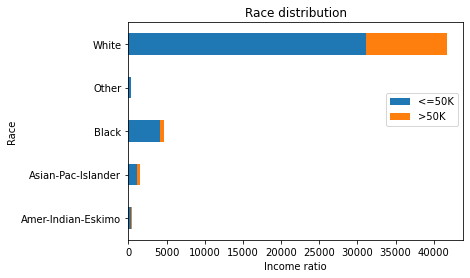

In [12]:
# race distribution; race vs income
race = data.groupby(['race', 'income']).size().unstack()
race.plot(kind='barh', stacked=True, legend=False)
plt.legend(['<=50K', '>50K'], bbox_to_anchor=(1.0, 0.7))
plt.ylabel('Race')
plt.xlabel('Income ratio')
plt.title("Race distribution")

## Data Preparation

Before feeding the data into the machine learning algorithm, we have to clean, format and restructure the data.

### Feature selection

In [13]:
# Split the data into features and target label
income = data['income']
features = data.drop('income',axis=1)

### Normalizing numerical features

Normalization ensures that each feature is treated equally when applying supervised learning

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Initiliaze a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain','capital-loss','hours-per-week']
features[numerical] = scaler.fit_transform(data[numerical])
features.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.109589,Private,11th,0.400000,Never-married,Machine-op-inspct,Own-child,Black,Male,0.000000,0.0,0.397959,United-States
1,0.287671,Private,HS-grad,0.533333,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.000000,0.0,0.500000,United-States
2,0.150685,Local-gov,Assoc-acdm,0.733333,Married-civ-spouse,Protective-serv,Husband,White,Male,0.000000,0.0,0.397959,United-States
3,0.369863,Private,Some-college,0.600000,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0.076881,0.0,0.397959,United-States
4,0.013699,NaN,Some-college,0.600000,Never-married,NaN,Own-child,White,Female,0.000000,0.0,0.295918,United-States


## Preprocessing

Learning algorithms require that we convert non-numerical features (categorical features) into numeric features. This can be done byb using one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature.

In [15]:
# One-hot encode the features using pandas.get_dummies()
features = pd.get_dummies(features)

# Encode the target label into numerical values
income = income.apply(lambda x: 1 if x == '>50K' else 0)

#Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

104 total features after one-hot encoding.


### Shuffle and split Data

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.3, random_state = 100)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 34189 samples.
Testing set has 14653 samples.


# Model performance evaluation

The charity foundation is more interested in predicting individuals who make more than $50,000 and we want our predictions to be as accurate as possible. There for using accuracy as a metric would be very appropriate. Additionally making false predictions would be very detrimental, therefore a model's ability to make correct predictions is more important than the model's ability to recall those individuals. I used F-beta score as a metric that considers both precision and recall

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0. I used a beta value of 0.5

# Model Training and Prediction

## Logistic Regression

I believe this model will be efficient in helping determine the probability whether a person makes more than $50,000 or not due to the target variable being binary. This model is easier to implement, intepret and very efficient to train

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, fbeta_score
logistic_model = LogisticRegression(max_iter=1000)

#model training
start = time()
logistic_model.fit(X_train,y_train)
end = time()
results['train_time'] = end - start # finding training time

# model prediction
start = time()
y_pred_logistic = logistic_model.predict(X_test) # make predictions for the testing set
end = time()
results['pred_time'] = end - start # finding prediction time

results['total_time'] = results['train_time'] + results['pred_time']

logistic_accuracy = accuracy_score(y_test,y_pred_logistic)
logistic_fbeta = fbeta_score(y_test,y_pred_logistic, beta = 0.5)
print("Our model's accuracy score is: {}.".format(logistic_accuracy))
print("Our model's fbeta score is: {}.".format(logistic_fbeta))
print(results)

Our model's accuracy score is: 0.8482222070565755.
Our model's fbeta score is: 0.6965006729475101.
{'train_time': 2.3252670764923096, 'pred_time': 0.019000530242919922, 'total_time': 2.3442676067352295}


C:\Users\Disleve Kanku\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Disleve Kanku\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


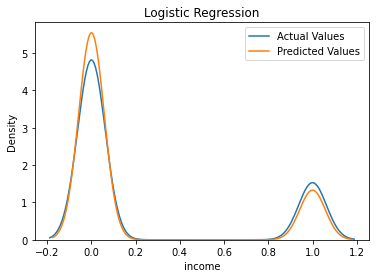

In [18]:
ax = sns.distplot(y_test,hist=False,label='Actual Values')
ax = sns.distplot(y_pred_logistic,hist=False,label='Predicted Values')
ax.set_title("Logistic Regression")
plt.legend()

## Support Vector Machines (SVM)

I chose this model because of its effectiveness given high dimensionality. after adding dummy variables, we have more than 100 features in our dataset.

In [35]:
from sklearn.svm import SVC

results = {}
svm_model = SVC(max_iter=1000)

# model training
start = time()
svm_model.fit(X_train,y_train)
end = time()
results['train_time'] = end - start # finding training time

#model prediction
start = time()
y_pred_svm = svm_model.predict(X_test) # make predictions for the testing set
end = time()
results['pred_time'] = end - start # finding prediction time

results['total_time'] = results['train_time'] + results['pred_time']

svm_accuracy = accuracy_score(y_test,y_pred_svm)
svm_fbeta = fbeta_score(y_test,y_pred_svm, beta = 0.5)
print("Our model's accuracy score is: {}.".format(svm_accuracy))
print("Our model's fbeta score is: {}.".format(svm_fbeta))
print(results)

C:\Users\Disleve Kanku\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Our model's accuracy score is: 0.7501535521736163.
Our model's fbeta score is: 0.5177966101694915.
{'train_time': 12.739222764968872, 'pred_time': 8.930583238601685, 'total_time': 21.669806003570557}


C:\Users\Disleve Kanku\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Disleve Kanku\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


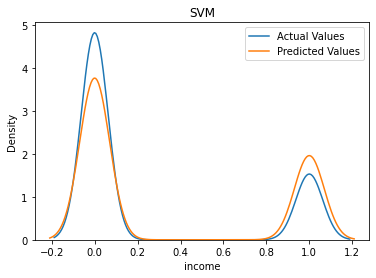

In [93]:
ax = sns.distplot(y_test,hist=False,label='Actual Values')
ax = sns.distplot(y_pred_svm,hist=False,label='Predicted Values')
ax.set_title("SVM")
plt.legend()

## Random Forest Classifier

This model makes highly accurate predictions and that's why I chose it. although this model increases the cost of computation compared to other algorithms, RF is a good choice for charity organizations where prediction accuracy is very important

In [40]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
# model training
start = time()
RF.fit(X_train,y_train)
end = time()
results['train_time'] = end - start # finding training time

# model training
start = time()
y_pred_RF = RF.predict(X_test) # make predictions for the testing set
end = time()
results['pred_time'] = end - start # finding prediction time

results['total_time'] = results['train_time'] + results['pred_time']

RF_accuracy = accuracy_score(y_test,y_pred_RF)
RF_fbeta = fbeta_score(y_test,y_pred_RF, beta = 0.5)
print("Our model's accuracy score is: {}.".format(RF_accuracy))
print("Our model's fbeta score is: {}.".format(RF_fbeta))
print (results)

Our model's accuracy score is: 0.8448781819422644.
Our model's fbeta score is: 0.6842536560766516.
{'train_time': 9.127439260482788, 'pred_time': 0.6427264213562012, 'total_time': 9.77016568183899}


C:\Users\Disleve Kanku\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Disleve Kanku\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


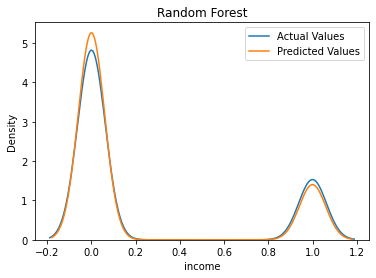

In [41]:
ax = sns.distplot(y_test,hist=False,label='Actual Values')
ax = sns.distplot(y_pred_RF,hist=False,label='Predicted Values')
ax.set_title("Random Forest")
plt.legend()

Looking at the results above, Logistic regression is the most appropriate model for our task

First and foremost, it performs the best in terms of both the accuracy and f-score. it also takes a small amount of time to train the dataset.